# **Sprint 13 - Proyecto**
---

## **Descripción del proyecto**

**Contexto**

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con clientes basada en datos analíticos.

Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un/a cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un/a cliente se haya ido: puede que se vaya de puntillas.

Los indicadores de pérdida varían de un campo a otro. Si un usuario o una usuaria compra en una tienda en línea con poca frecuencia, pero con regularidad, no se puede decir que ha huido. Pero si durante dos semanas no ha abierto un canal que se actualiza a diario, es motivo de preocupación: es posible que tu seguidor o seguidor/a se haya aburrido y te haya abandonado.

En el caso de un gimnasio, tiene sentido decir que un/a cliente se ha ido si no viene durante un mes. Por supuesto, es posible que estén en Cancún y retomen sus visitas cuando regresen, pero ese no es un caso típico. Por lo general, si un/a cliente se une, viene varias veces y luego desaparece, es poco probable que regrese.

Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Tu tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

Tienes que:

- Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.

- Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.

- Analizar los factores que más impactan la pérdida.

- Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:

    - Identificar a los grupos objetivo;
    - Sugerir medidas para reducir la rotación;
    - Describir cualquier otro patrón que observes con respecto a la interacción con los clientes.

## **Desarrollo del proyecto**
- [Paso 1. Descripcion de los datos](#paso-1-descripcion-de-los-datos)
- [Paso 2. Llevar a cabo el análisis exploratorio de datos (EDA)](#paso-2-llevar-a-cabo-el-analisis-exploratorio-de-datos-eda)
- [Paso 3. Construir un modelo para predecir la cancelación de usuarios](#paso-3-construir-un-modelo-para-predecir-la-cancelacion-de-usuarios)
- [Paso 4. Crear clústeres de usuarios/as](#paso-4-crear-clusteres-de-usuarios)
- [Paso 5. Saca conclusiones y haz recomendaciones básicas sobre el trabajo con clientes](#paso-5-saca-conclusiones-y-haz-recomendaciones-basicas-sobre-el-trabajo-con-clientes)




### **Paso 1. Descripcion de los datos**
---

Model Fitness te aportó archivos CSV que contienen los datos sobre la cancelación de un mes en concreto e información del mes que lo precedía. El dataset incluye los siguientes campos:

- `'Churn'` — la cancelación para el mes en cuestión

- Campos de dataset actuales:

    - Datos del usuario del mes anterior
        
        - `'gender'`.
        
        - `'Near_Location'` — si el/la usuario/a vive o trabaja en el vecindario donde se encuentra el gimnasio.
        
        - `'Partner'` — si el/la usuario/a trabaja en una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes).
        
        - `Promo_friends` — si el/la usuario/a originalmente se inscribió mediante una oferta “trae a un/a amigo/a” (se utilizó el código promocional de un/a amigo/a cuando pagaron el primer abono).
        
        - `'Phone'` — si el/la usuario/a aportó el número de teléfono.
        
        - `'Age'`.
        
        - `'Lifetime'` — el tiempo (en meses) desde que el/la usuario/a llegó por primera vez al gimnasio.
- Datos del registro de visitas y compras y datos sobre el estado actual de la membresía:
    - `'Contract_period'` — 1 mes, 3 meses, 6 meses o 1 año.
    
    - `'Month_to_end_contract'` — los meses que faltan hasta que expire el contrato.
    
    - `'Group_visits'` — si el/la usuario/a participa en sesiones grupales.
    
    - `'Avg_class_frequency_total'` — frecuencia media de visitas por semana a lo largo de la vida del cliente.
    
    - `'Avg_class_frequency_current_month'` — frecuencia media de visitas por semana durante el mes en curso.
    
    - `'Avg_additional_charges_total'` — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

In [1]:
# Librerías
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# Cargar datos en Dataframe
gym_churn = pd.read_csv('datasets/gym_churn_us.csv')

# Estandarizando nombres de columnas
column_names = [] # Lista vacía
for column in gym_churn.columns:
    column = column.strip().lower().replace(' ','_')
    column_names.append(column)
# Cambiando nombres de columnas
gym_churn.columns = column_names

# Mostrar primeras 5 líneas
display(gym_churn.head(5))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0



### **Paso 2. Llevar a cabo el analisis exploratorio de datos EDA**
---

- **Observa el dataset:** (utiliza el método `describe()`).

In [3]:
# Método describe()
display(gym_churn.describe())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


###############################################################################

**¿Contiene alguna característica ausente? Estudia los valores promedio y la desviación estándar**

***OBSERVACIONES:***

1. No existen valores ausentes en el DataFrame. 
2. Se observa que muchas de las categorías son del tipo binario (Donde 1 = True y 0 = False).
3. En las columnas no-booleanas, en general no cuentan con desviación estándar muy elevada.
4. Únicamente la columna *'Avg_additional_charges_total'* presenta una desviación estándar relativamente alta y se observa una lejanía relevante entre el percentil 75% y el valor máximo.

###############################################################################

- **Observa los valores medios de las características en dos grupos:** para las personas que se fueron (cancelación) y para las que se quedaron (utiliza el método `groupby()`).



In [4]:
# Calculando el número de usuarios activos (0) y usuarios perdidos (1)
print(gym_churn['churn'].value_counts())

churn
0    2939
1    1061
Name: count, dtype: int64


In [5]:
# Valores medios de las caracteristicas
display(gym_churn.groupby(by='churn', as_index=False).mean())

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


##############################################################################

***OBSERVACIONES:***

1. Se cuenta con 2,939 registros de clintes todavía activos y 1,061 registros de clientes que se han dado de baja (**%26.5 del total de los registros.**)

2. Se observan los diferentes comportamientos de cada grupo de clientes, por ejemplo es posible ver que el de los clientes que se han dado de baja, el solo el 35.5% trabaja en una compañia asociada al gimnasio para los clientes que siguen activos es el %53.4. Esto podría indicar que es una caracteristica relevante.

3. Algo similar ocurre en 'contract_period', los clientes perdidos en promedio contratan por periodos mucho mas cortos (1.72 meses) que lo que siguen activos (5.74 meses).

##############################################################################

- **Traza histogramas de barras y distribuciones de características para aquellas personas que se fueron (cancelación) y para las que se quedaron.**

In [6]:
# Separando en 2 DataFrames
gym_churn_0 = gym_churn.query('churn == 0')
gym_churn_1 = gym_churn.query('churn == 1')


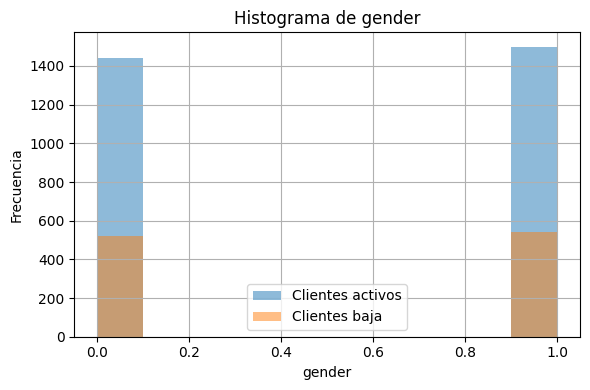

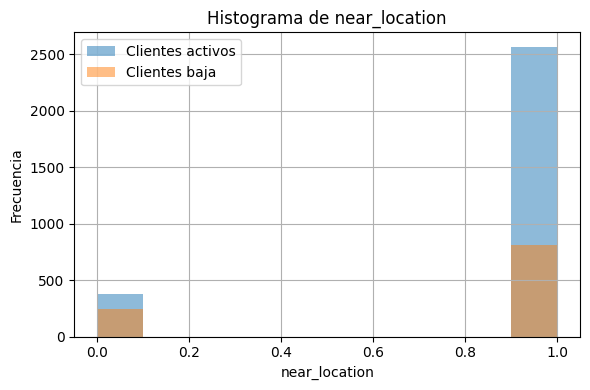

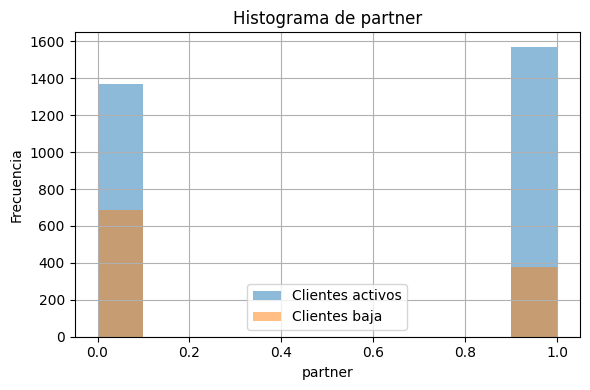

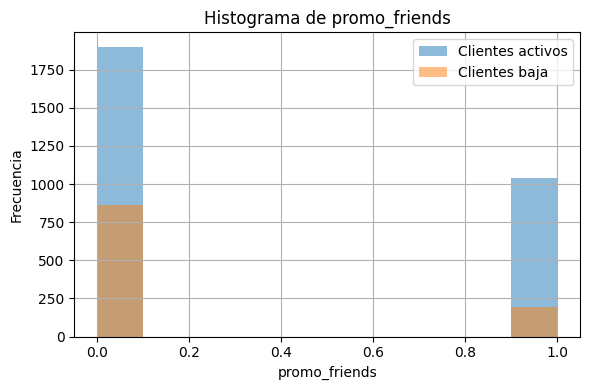

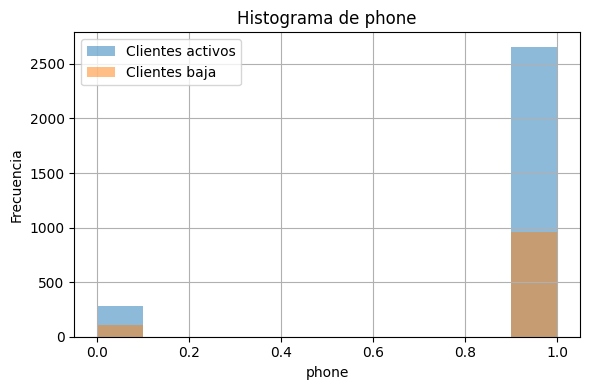

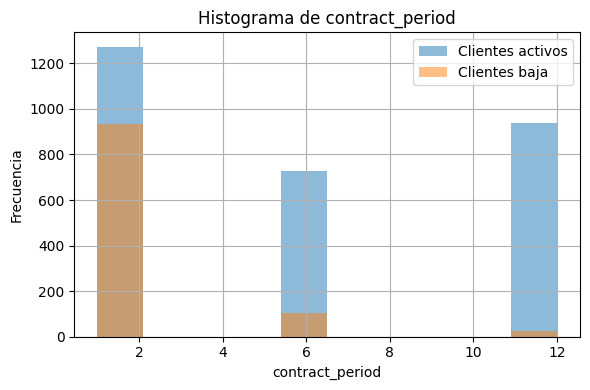

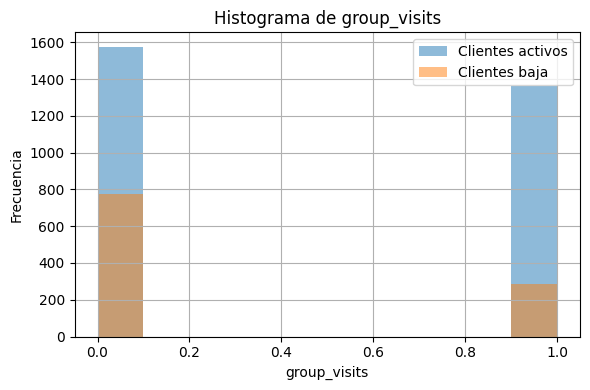

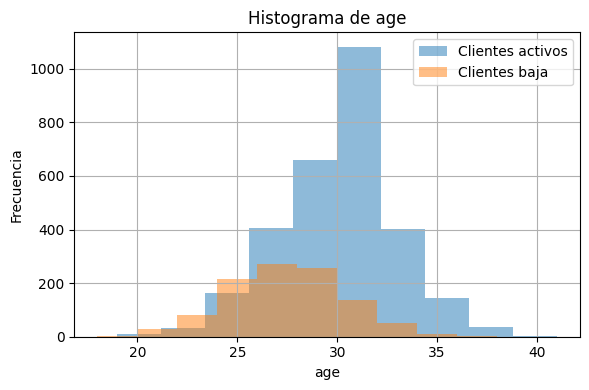

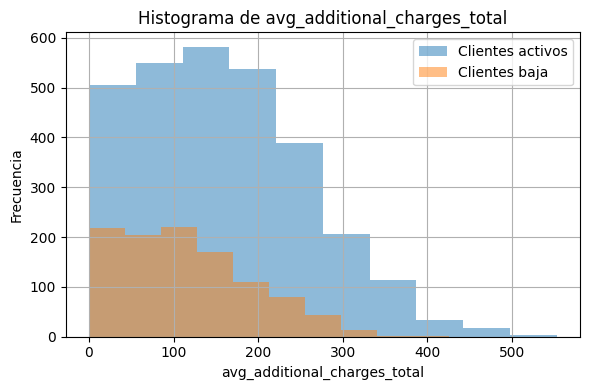

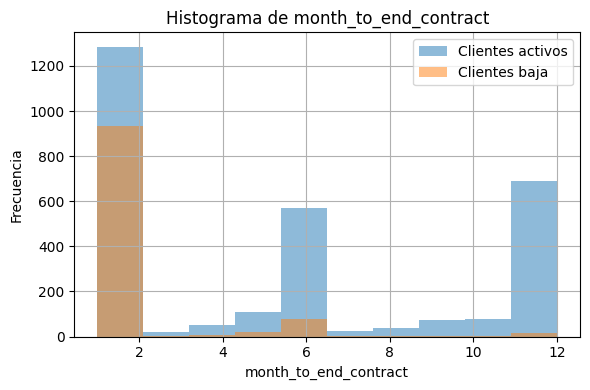

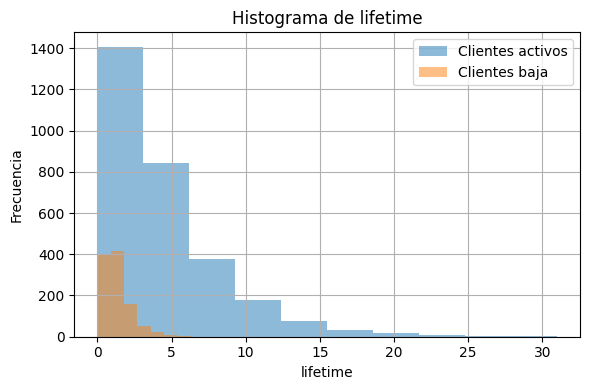

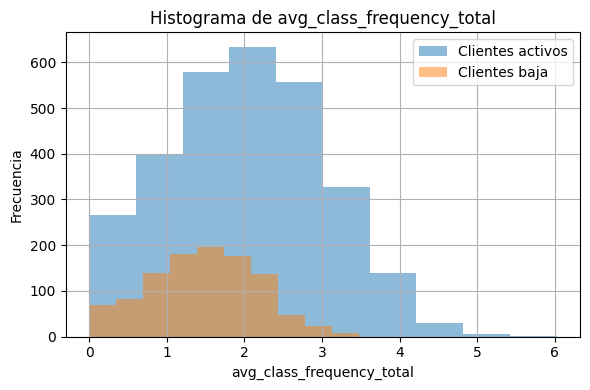

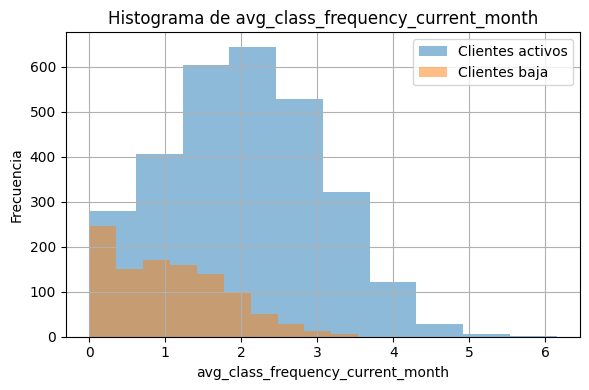

In [7]:
# Graficar histogramas superpuestos para cada columna
for col in gym_churn.drop('churn', axis=1):
    plt.figure(figsize=(6, 4))
    plt.hist(gym_churn_0[col], alpha=0.5, label='Clientes activos')
    plt.hist(gym_churn_1[col], alpha=0.5, label='Clientes baja')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- **Crea una matriz de correlación y muéstrala.**

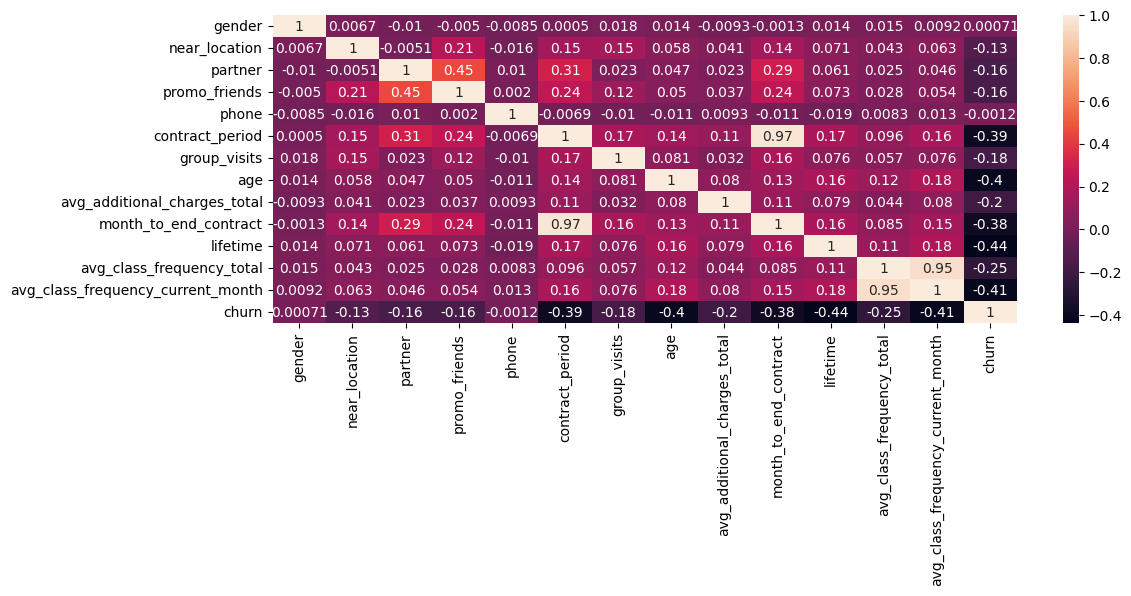

In [8]:
# Matriz de correlación
cm = gym_churn.corr() # calcula la matriz de correlación

# Mapa de calor para la matriz de correlación
plt.figure(figsize=(12,4))
sns.heatmap(cm, annot = True)
plt.show()

##############################################################################

***OBSERVACIONES:***

1. No se observan valores atípicos obvios en los diagramas.
2. De acuerdo a la matriz de correlación, **no se observan características fuertemente correlacionadas con la variable objetivo "churn"**.
3. Se observa que las caracteristicas cuentan con correlación negativa, quiere decir que entre mayor sea el valor de la característica, menor es el valor de la variable objetivo.
4. Las variables *'lifetime', 'avg_class_frequency_current_mont', 'age', 'contract_period' y 'month_to_end_contract'* tiene una **correlación negativa moderada.** 
5. EDA ayuda a tener un vistazo rápido de los datos, entenderlos mejor. En este caso **se puede apreciar a simple vista el impacto de cada varible.** 

##############################################################################


### **Paso 3. Construir un modelo para predecir la cancelacion de usuarios**
---

Crea un modelo de clasificación binaria para clientes donde la característica objetivo es la marcha del usuario o la usuaria el mes siguiente.

- **Divide los datos en conjuntos de entrenamiento y validación utilizando la función `train_test_split()`.**

In [9]:
# Dividiendo los datos en características (matriz X) y variable objetivo (y)
X = gym_churn.drop('churn',axis=1)
y = gym_churn['churn']

# Dividiendo los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objeto StandardScaler para estandarizar valores
scaler = StandardScaler() 

X_train_st = scaler.fit_transform(X_train) # entrena el scaler y transforma matriz de entrenamiento
X_test_st = scaler.transform(X_test) # transforma la matriz de característica test


- **Entrena el modelo en el set de entrenamiento con dos métodos:**

    - regresión logística;

    - bosque aleatorio.

In [10]:
# Modelo regresión logística
modelo_rl = LogisticRegression(random_state=42)
modelo_rl.fit(X_train_st,y_train)
y_pred_rl = modelo_rl.predict(X_test_st) # Predicción

# Modelo bosque aleatorio
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train_st,y_train)
y_pred_rf = modelo_rf.predict(X_test_st) # Predicción

- **Evalúa la exactitud, precisión y recall para ambos modelos utilizando los datos de validación. Utilízalos para comparar los modelos.**

In [11]:
# Métricas para modelo de regresión logística
print('>>> REGRESIÓN LOGISTICA <<<')
print('Exactitud regresión logistica: {:.2f}'.format(accuracy_score(y_test, y_pred_rl)))
print('Precisión regresión logistica: {:.2f}'.format(precision_score(y_test, y_pred_rl)))
print('Recall regresión logistica: {:.2f}'.format(recall_score(y_test, y_pred_rl)))
print('\n')
# Métricas para modelo bosque aleatorio
print('>>> BOSQUE ALEATORIO <<<')
print('Exactitud bosque aleatorio: {:.2f}'.format(accuracy_score(y_test, y_pred_rf)))
print('Precisión bosque aleatorio: {:.2f}'.format(precision_score(y_test, y_pred_rf)))
print('Recall bosque aleatorio: {:.2f}'.format(recall_score(y_test, y_pred_rf)))

>>> REGRESIÓN LOGISTICA <<<
Exactitud regresión logistica: 0.92
Precisión regresión logistica: 0.87
Recall regresión logistica: 0.78


>>> BOSQUE ALEATORIO <<<
Exactitud bosque aleatorio: 0.91
Precisión bosque aleatorio: 0.85
Recall bosque aleatorio: 0.78


##############################################################################

***¿Qué modelo dio mejores resultados?***

Ambos modelos obtuvieron resultados muy buenos, las métricas están muy cercanas. El modelo de **regresión logistica es ligeramente mejor** en algunas métricas.

##############################################################################


### **Paso 4. Crear clusteres de usuarios**
---

Deja de lado la columna con datos sobre la cancelación e identifica los clústeres de objetos (usuarios/as):

- **Estandariza los datos.**



In [12]:
# Objeto StandardScaler para estandarizar valores
sc = StandardScaler() 

X_sc = sc.fit_transform(X) # Estandarización de datos

- **Utiliza la función `linkage()` para crear una matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma.** 

Utiliza el gráfico resultante para estimar el número de clústeres que puedes destacar.



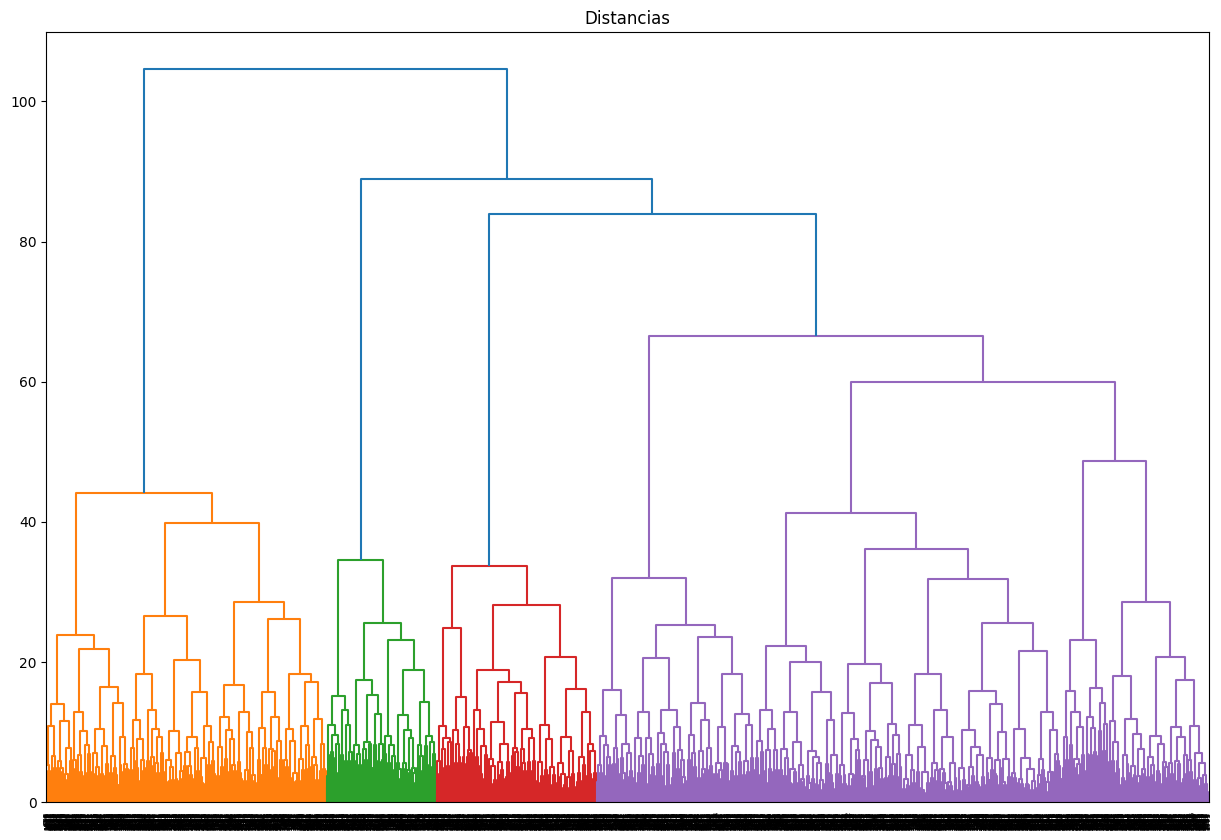

In [13]:
linked = linkage(X_sc, method = 'ward') # Almacena la tabla con los haces de objetos vinculados.
# Mostrando gráfico de distancias
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Distancias')
plt.show()

- **Entrena el modelo de *clustering* con el algortimo K-means y predice los clústeres de clientes. (Deja que el número de clústeres sea `n=5` para que sea más sencillo comparar los resultados con los del resto del estudiantado. Sin embargo, en la vida real, nadie te dará tales pistas, así que tendrás que decidir basándote en el gráfico del paso anterior.)**



In [14]:
# Creando objeto de modelo KMeans
km = KMeans(n_clusters = 5, random_state=42) # Objeto KMeans()
labels = km.fit_predict(X_sc) # Entrenar y predecir

# Agregando etiquetas de cluster a df
X['cluster'] = labels

- **Mira los valores medios de característica para los clústeres.**

In [15]:
# Valores medio de las características para cada cluster
display(X.groupby('cluster', as_index=False).mean())

,cluster,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.484801,0.698363,0.301637,0.007015,0.899454,1.733437,0.255651,28.074825,127.131782,1.657833,2.089634,1.256531,0.991781
1,1,0.494471,0.947867,0.791469,0.998420,0.906793,2.740916,0.431280,28.903633,139.456908,2.540284,3.529226,1.619489,1.488508
2,2,0.464396,0.913313,0.766254,0.493808,0.925697,10.495356,0.506192,30.091331,164.190347,9.484520,4.693498,2.888801,2.886027
3,3,0.547794,0.937500,0.742647,0.424632,0.863971,11.194853,0.575368,29.720588,167.670439,10.347426,4.818015,1.154578,1.139605
4,4,0.568233,0.878076,0.178971,0.048098,0.914989,2.120805,0.456376,29.993289,155.602830,2.013423,4.844519,2.667290,2.650122


##############################################################################

***¿Hay algo que te llame la atención?***

Al analizar el comportamiento promedio de los usuarios por clúster, se observan contrastes importantes en varias variables. Por ejemplo, en la columna 'near_location', el clúster 0 presenta un valor promedio considerablemente inferior al de los demás (69.83 %). Algo similar ocurre con la variable 'partner', donde los clústeres 0 y 4 muestran los promedios más bajos. En cuanto a 'contract_period', se evidencia que los clústeres 0, 1 y 4 tienden a contratar membresías por periodos significativamente más cortos.

El caso más notorio se encuentra en la variable 'promo_friends', donde apenas el 0.7 % de los usuarios del clúster 0 hizo uso de promociones por inscripción con amigos.

Existen otras características como la edad ('age') donde los clusters no presentan contraste marcados.

##############################################################################

- **Traza distribuciones de características para los clústeres. ¿Notas algo?**


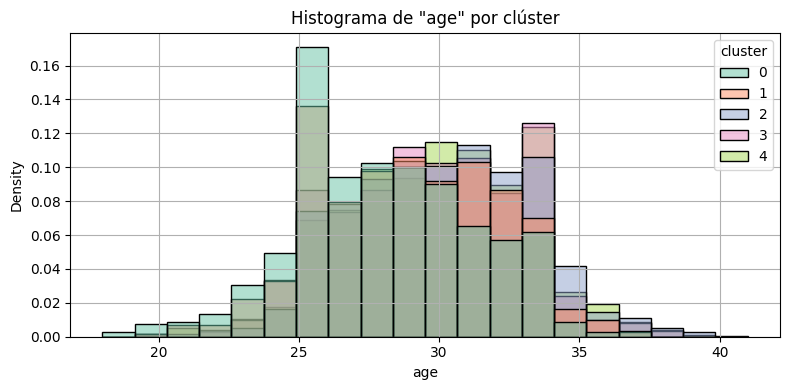

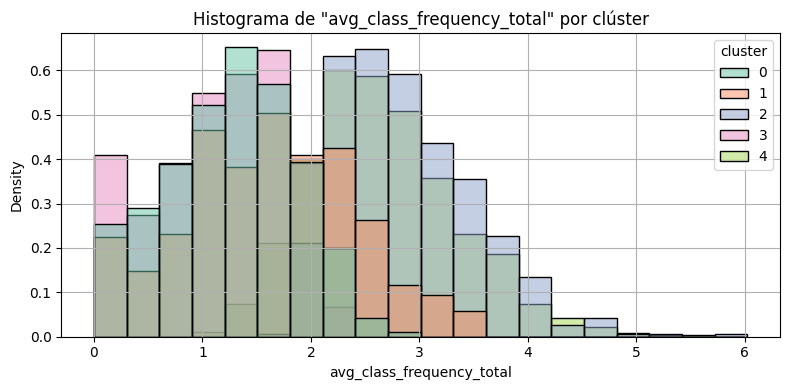

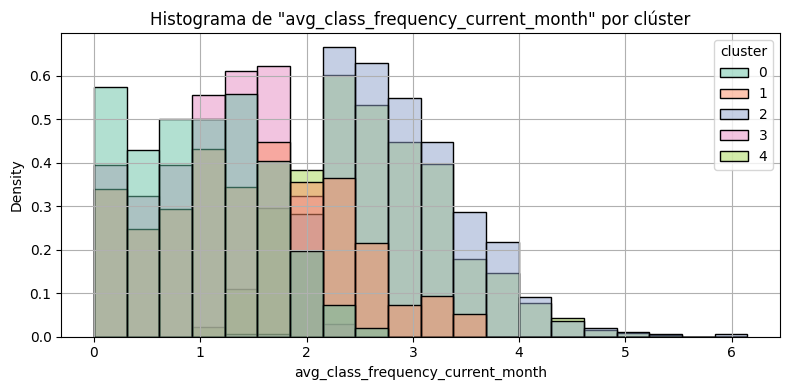

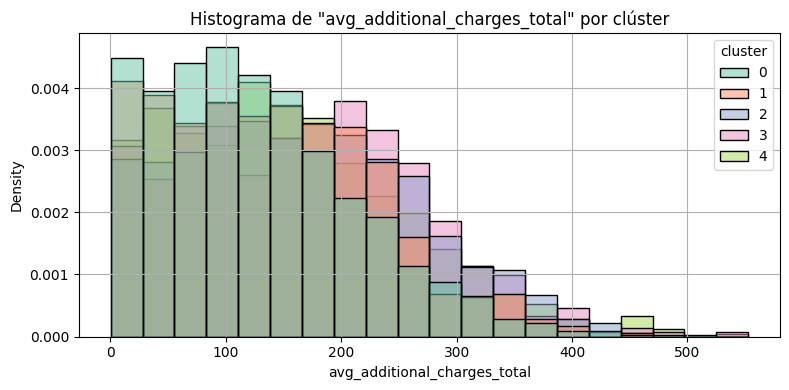

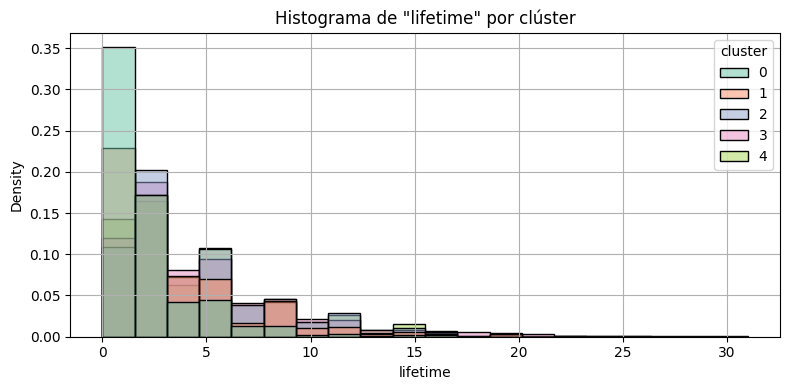

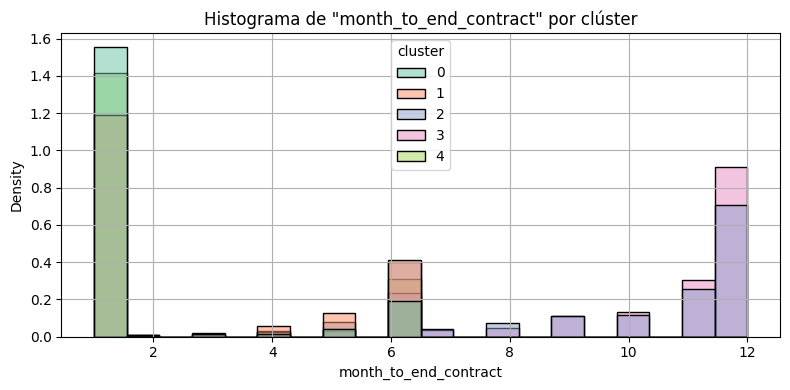

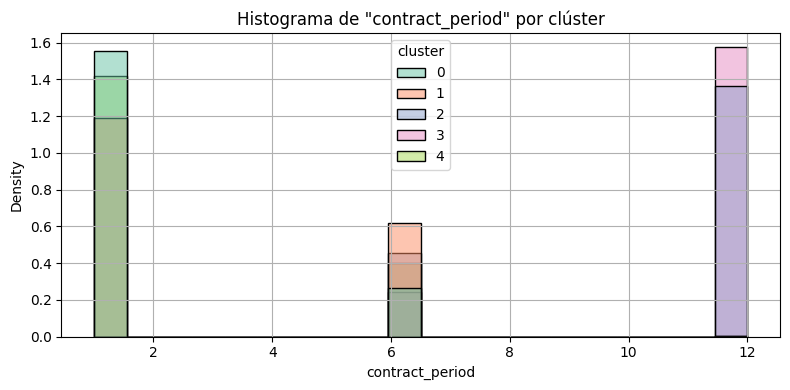

In [16]:
# Lista de características numéricas que quieres analizar
caracteristicas = [
    'age', 'avg_class_frequency_total', 'avg_class_frequency_current_month',
    'avg_additional_charges_total', 'lifetime', 'month_to_end_contract', 'contract_period'
]

# Creación de gráfico para cara característica
for caracteristica in caracteristicas:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=X, x=caracteristica, hue='cluster', bins=20, stat='density', alpha=0.5, palette='Set2', common_norm=False)
    plt.title(f'Histograma de "{caracteristica}" por clúster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

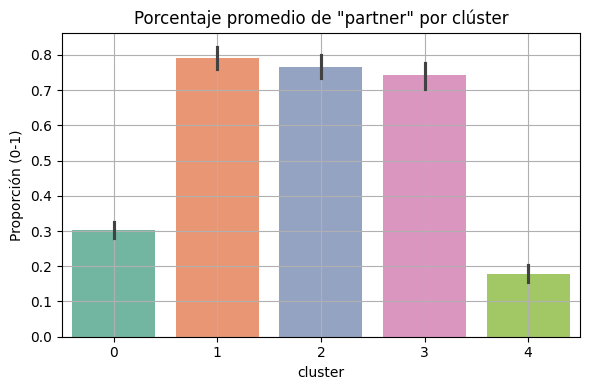

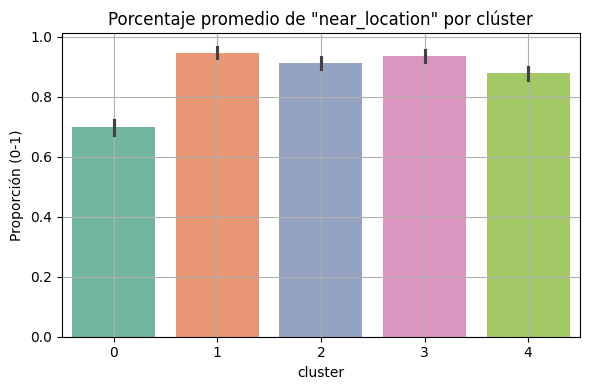

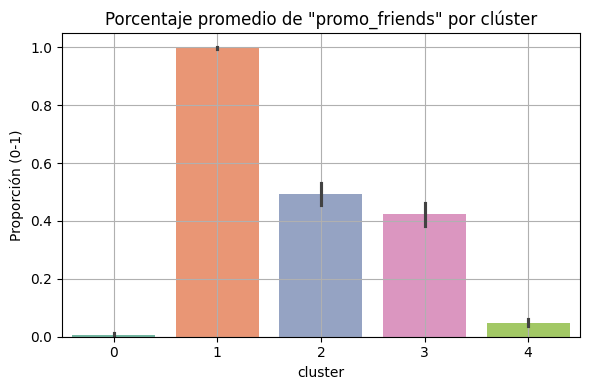

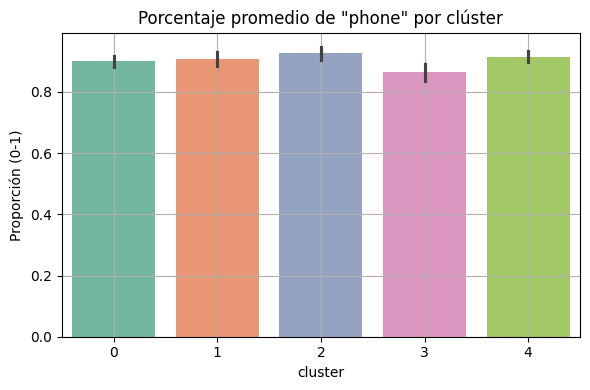

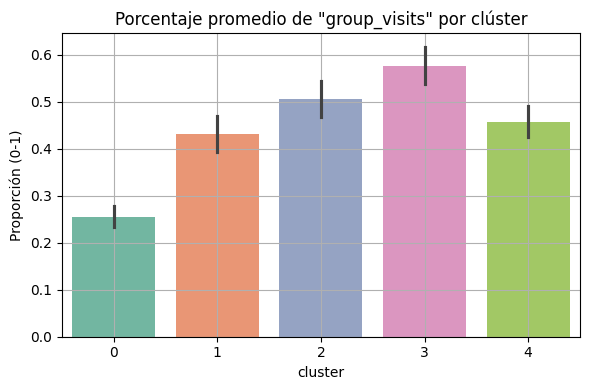

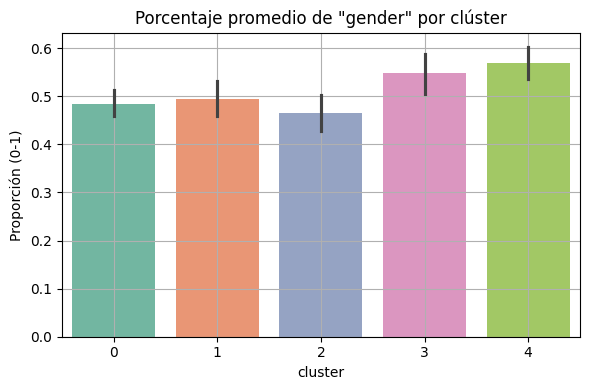

In [17]:
# Lista de caracteristicas binarias
caracteristicas_binarias = ['partner', 'near_location', 'promo_friends', 'phone', 'group_visits', 'gender']
# Creación de gráfico para cara característica
for caracteristica in caracteristicas_binarias:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=X, x='cluster', hue='cluster', y=caracteristica, estimator='mean',palette='Set2', legend=False)
    plt.title(f'Porcentaje promedio de "{caracteristica}" por clúster')
    plt.ylabel('Proporción (0-1)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


- **Calcula la tasa de cancelación para cada clúster (utiliza el método `groupby()`).**

In [18]:
# Agregando etiquetas de clisters a df "gym_churn" (que incluye la columna 'churn')
gym_churn['cluster'] = labels
# Calculando tasa de cancelación y conteo de clientes para cada cluster 
cluster_churn_rate = gym_churn.groupby('cluster', as_index=False).agg(churn_rate=('churn','mean'), client_count=('gender','count'))
# Mostrando datos obtenidos
display(cluster_churn_rate.sort_values(by='churn_rate', ascending=False))

,cluster,churn_rate,client_count
0,0,0.587685,1283
1,1,0.285940,633
4,4,0.105145,894
3,3,0.042279,544
2,2,0.013932,646


##############################################################################

***¿Difieren en términos de tasa de cancelación? ¿Qué grupos son propensos a irse y cuáles son leales?***

Las tasas de cancelación varían considerablemente entre los clústeres. Los grupos más propensos a abandonar son el clúster 0 y el clúster 1, con tasas de 58.76 % y 28.59 %, respectivamente. En contraste, los clústeres 2 y 3 muestran mayor fidelidad, con tasas de cancelación de apenas 1.39 % y 4.22 %. Por su parte, el clúster 4 presenta una tasa de cancelación del 10.5 %; aunque no es particularmente alta, aún ofrece margen para mejorar.

##############################################################################


### **Paso 5. Saca conclusiones y haz recomendaciones basicas sobre el trabajo con clientes**
---

- El clúster 0 concentra la mayor cantidad de usuarios con diferencia (1,283) y presenta la tasa de cancelación más alta, por lo que requiere especial atención.

- Se recomienda realizar un análisis más detallado dentro de los clústeres con mayor tasa de cancelación para identificar posibles subgrupos con comportamientos diferenciados. En particular, para el clúster 0, es conveniente examinar sus patrones de comportamiento a mayor profundidad con el fin de detectar áreas de oportunidad que permitan reducir la tasa de cancelación.

- Se recomienda comparar los gráficos generados para el clúster con la tasa de cancelación más baja (clúster 2) y el clúster con la tasa más alta (clúster 0). Esta comparación visual permite identificar los factores que diferencian a ambas poblaciones, lo cual puede servir como base para diseñar campañas de marketing personalizadas y más efectivas según el perfil de cada tipo de usuario.

- **Clúster 0 vs Clúster 2**

    A continuación, se presentan las principales diferencias identificadas entre los usuarios de ambos clústeres:

    `avg_class_frequency_total` y `avg_class_frequency_current_month`:

    Se observa una diferencia notable en la frecuencia semanal de visitas al gimnasio. Los usuarios del clúster 0 suelen asistir menos de dos veces por semana, mientras que los del clúster 2 asisten más de dos veces por semana.

    `month_to_end_contract` y `contract_period`:

    La mayoría de los usuarios del clúster 0 se encuentran en su último mes de contrato, lo cual está estrechamente relacionado con la corta duración de los contratos que contratan. Esto sugiere que quienes optan por periodos breves tienen una mayor probabilidad de cancelar el servicio.

    `partner`:

    El clúster 2 está conformado en su mayoría por usuarios vinculados a empresas asociadas al gimnasio (76.6 %), en contraste con el clúster 0, donde solo el 30.1 % presenta esta condición. Esta afiliación podría estar asociada con una mayor fidelidad.

    `promo_friends`:

    En el clúster 2, el 99.84 % de los clientes se inscribieron a través de la promoción “trae a un amigo”, mientras que en el clúster 0 apenas el 0.7 % lo hizo. Esto indica una fuerte diferencia en el tipo de captación de clientes.

    `group_visits`:

    En el clúster 2, el 50.6 % de los usuarios participa en clases o actividades grupales, frente al 25.5 % en el clúster 0. Este comportamiento sugiere que los usuarios más activos socialmente dentro del gimnasio tienden a mostrar mayor fidelidad al servicio.

#### **Cluster 0 vs Cluster 2** (Gráficos)

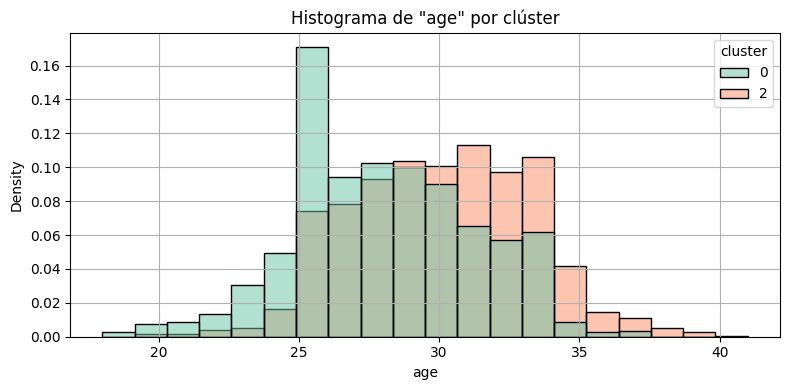

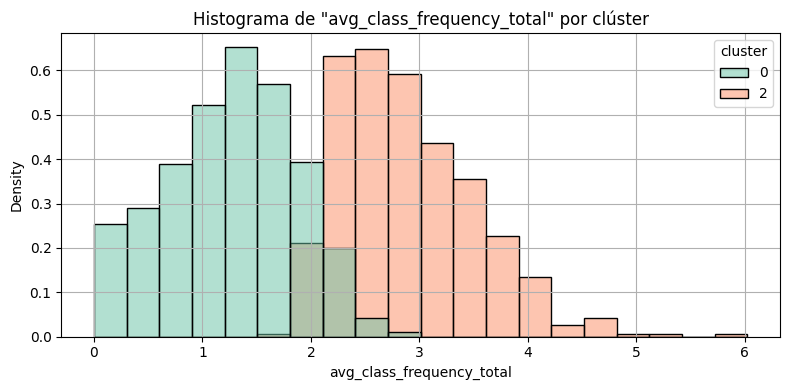

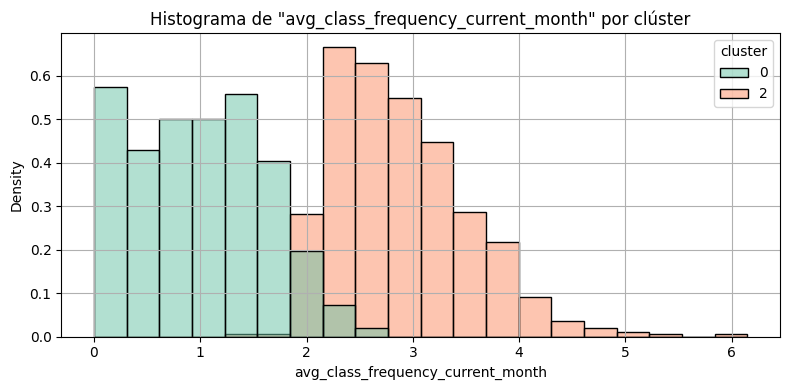

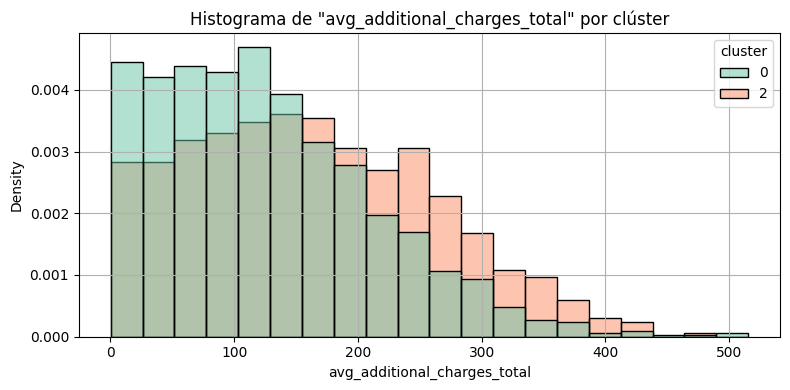

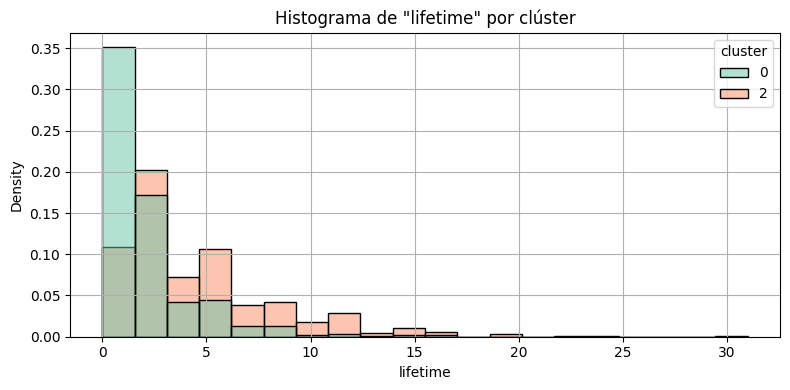

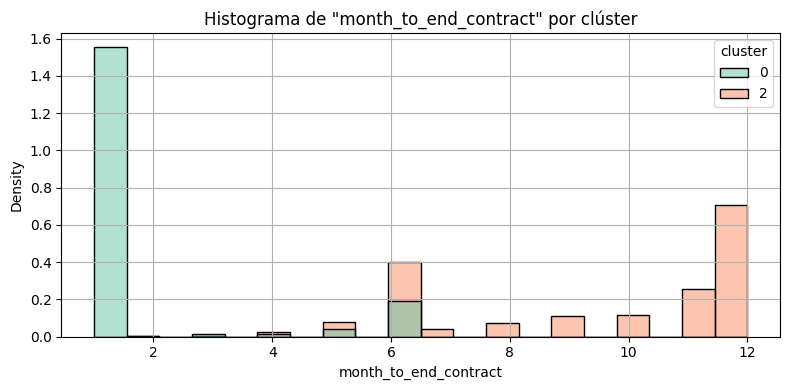

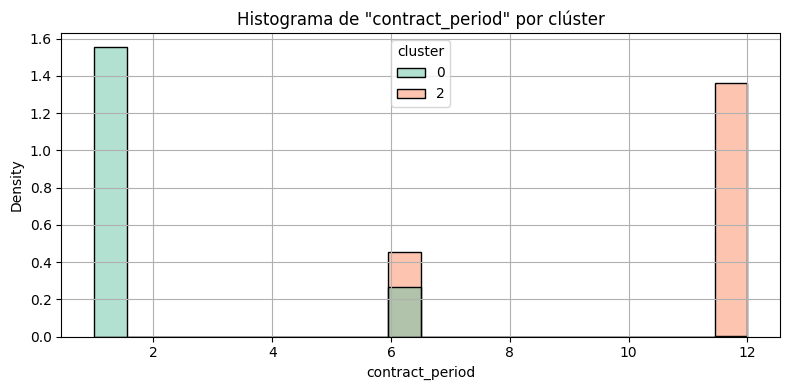

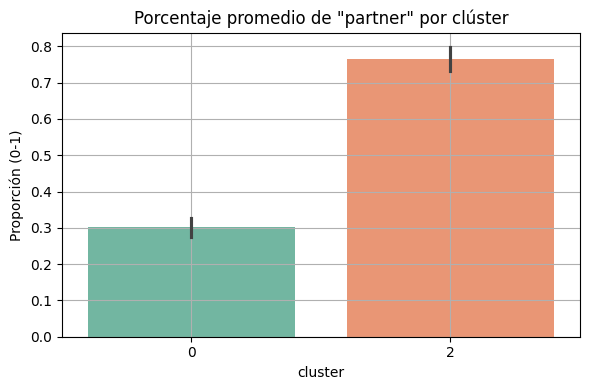

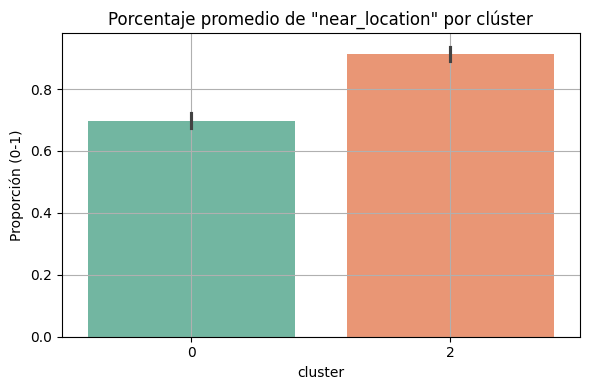

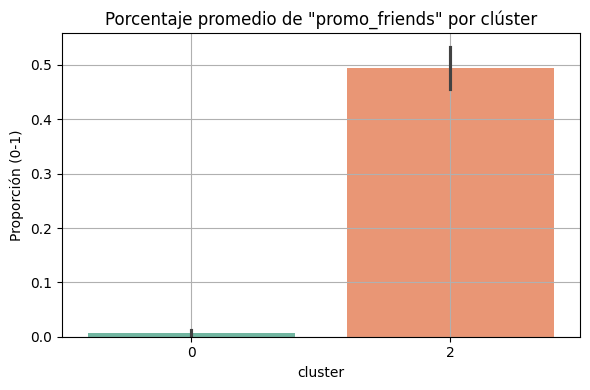

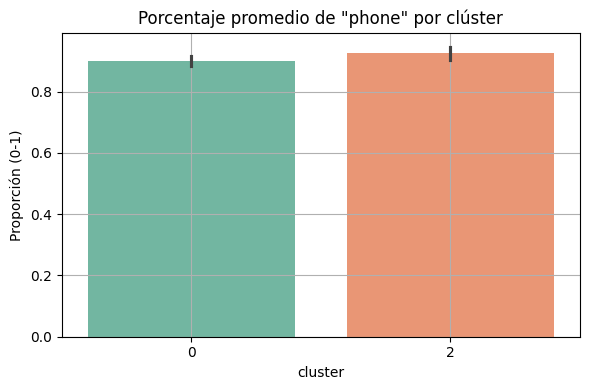

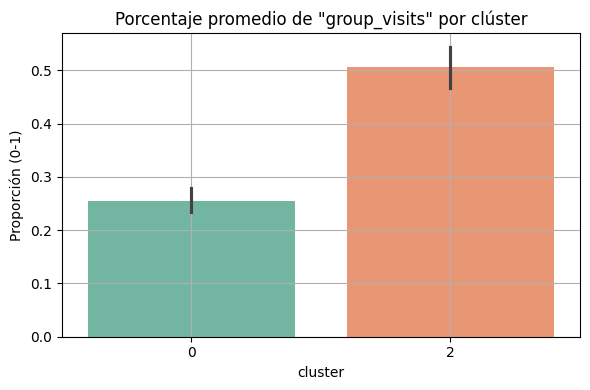

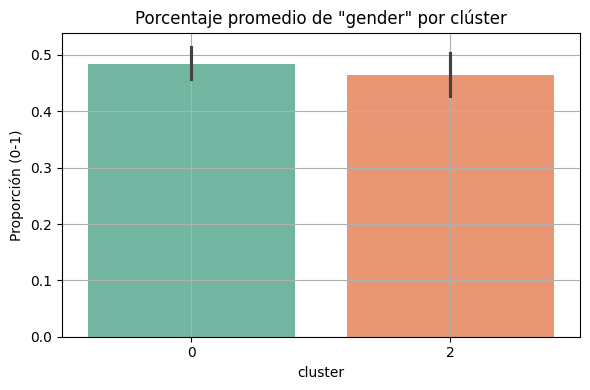

In [19]:
# Lista de características numéricas que quieres analizar
caracteristicas = [
    'age', 'avg_class_frequency_total', 'avg_class_frequency_current_month',
    'avg_additional_charges_total', 'lifetime', 'month_to_end_contract', 'contract_period'
]

for caracteristica in caracteristicas:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=X.query('cluster in [0,2]'), x=caracteristica, hue='cluster', bins=20, stat='density', alpha=0.5, palette='Set2', common_norm=False)
    plt.title(f'Histograma de "{caracteristica}" por clúster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

caracteristicas_binarias = ['partner', 'near_location', 'promo_friends', 'phone', 'group_visits', 'gender']

for caracteristica in caracteristicas_binarias:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=X.query('cluster in [0,2]'), x='cluster', hue='cluster', y=caracteristica, estimator='mean',palette='Set2', legend=False)
    plt.title(f'Porcentaje promedio de "{caracteristica}" por clúster')
    plt.ylabel('Proporción (0-1)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()